In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

https://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html

In [2]:
from __future__ import division
import tensorflow as tf
from os import path
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from IPython.display import Image
from IPython.core.display import HTML
from mylibs.tf_helper import getDefaultGPUconfig
from data_providers.binary_shifter_varlen_data_provider import \
    BinaryShifterVarLenDataProvider
from data_providers.price_history_varlen_data_provider import PriceHistoryVarLenDataProvider
from models.model_05_price_history_rnn_varlen import PriceHistoryRnnVarlen
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from cost_functions.huber_loss import huber_loss

/home/student/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
%matplotlib inline

In [4]:
from common import get_or_run_nn

### Step 0 - hyperparams

In [5]:
num_epochs = 10
series_max_len = 60
num_features = 1  #just one here, the function we are predicting is one-dimensional
state_size = 400
target_len = 30
batch_size = 47

### Step 1 - collect data (and/or generate them)

In [6]:
csv_in = '../price_history_03a_fixed_width.csv'
npz_path = '../price_history_03_dp_60to30_from_fixed_len.npz'

In [7]:
# XX, YY, sequence_lens, seq_mask = PriceHistoryVarLenDataProvider.createAndSaveDataset(
#     csv_in=csv_in,
#     npz_out=npz_path,
#     input_seq_len=60, target_seq_len=30)
# XX.shape, YY.shape, sequence_lens.shape, seq_mask.shape

In [8]:
dp = PriceHistoryVarLenDataProvider(filteringSeqLens = lambda xx : xx >= target_len,
                                    npz_path=npz_path)
dp.inputs.shape, dp.targets.shape, dp.sequence_lengths.shape, dp.sequence_masks.shape

((11374, 60, 1), (11374, 30), (11374,), (11374, 60))

### Step 2 - Build model

In [9]:
model = PriceHistoryRnnVarlen(rng=random_state, dtype=dtype, config=config)

In [10]:
graph = model.getGraph(batch_size=batch_size, state_size=state_size,
                       rnn_cell= PriceHistoryRnnVarlen.RNN_CELLS.GRU,
                       target_len=target_len, series_max_len=series_max_len)

learning rate: 0.001000
rnn_outputs:
Tensor("rnn_layer/rnn/transpose:0", shape=(47, 60, 400), dtype=float32)

Tensor("gathering/GatherNd:0", shape=(47, 30, 400), dtype=float32)

Tensor("flattening:0", shape=(1410, 400), dtype=float32)
Tensor("readout_layer/add:0", shape=(1410, 1), dtype=float32)

Tensor("predictions/Reshape:0", shape=(47, 30), dtype=float32)

Tensor("error/Select:0", shape=(47, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)



In [11]:
show_graph(graph)

### Step 3 training the network

## GRU cell

In [12]:
rnn_cell = PriceHistoryRnnVarlen.RNN_CELLS.GRU
num_epochs, state_size, batch_size

(10, 400, 47)

In [13]:
def experiment():
    dynStats, predictions_dict = model.run(epochs=num_epochs,
                                           rnn_cell=rnn_cell,
                                           state_size=state_size,
                                           series_max_len=series_max_len,
                                           target_len=target_len,
                                           npz_path=npz_path,
                                           batch_size=batch_size)
    return dynStats, predictions_dict

In [14]:
from os.path import isdir
data_folder = '../../../../Dropbox/data'
assert isdir(data_folder)

In [15]:
dyn_stats, preds_dict = get_or_run_nn(experiment,
                                      filename='002_rnn_gru_60to30', nn_runs_folder= data_folder + '/nn_runs')

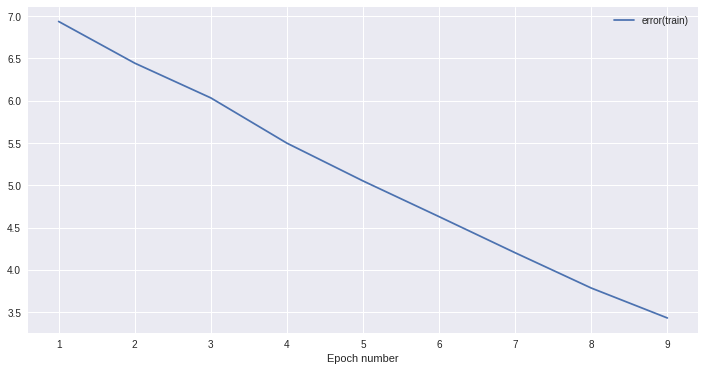

In [16]:
dyn_stats.plotStats()
plt.show()

In [17]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [18]:
ind = np.argmin(r2_scores)
ind

3918

In [19]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [20]:
r2_score(y_true=reals, y_pred=preds)

-1.7898149900928367e+31

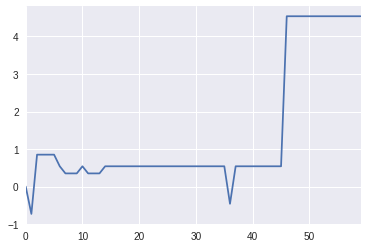

In [21]:
sns.tsplot(data=dp.inputs[ind].flatten())

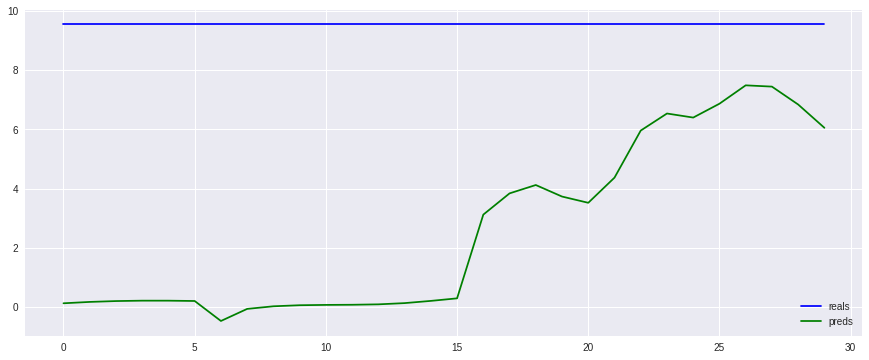

In [22]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [23]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 23.8 s, sys: 112 ms, total: 24 s
Wall time: 23.8 s


In [24]:
np.mean(dtw_scores)

97.121502617895061

In [25]:
coint(preds, reals)

(-2.306996326148862,
 0.3700669207661037,
 array([-4.31395736, -3.55493606, -3.19393252]))

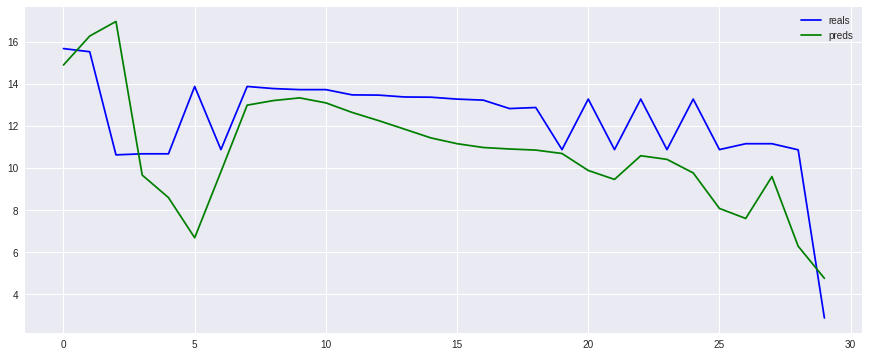

In [26]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [27]:
average_huber_loss = np.mean([np.mean(huber_loss(dp.targets[ind], preds_dict[ind]))
                              for ind in range(len(dp.targets))])
average_huber_loss

3.2655817839983405

#### Conclusion
GRU has performed much better than basic RNN

## GRU cell - 50 epochs

In [28]:
rnn_cell = PriceHistoryRnnVarlen.RNN_CELLS.GRU
num_epochs = 50
state_size, batch_size

(400, 47)

In [29]:
def experiment():
    dynStats, predictions_dict = model.run(epochs=num_epochs,
                                           rnn_cell=rnn_cell,
                                           state_size=state_size,
                                           series_max_len=series_max_len,
                                           target_len=target_len,
                                           npz_path=npz_path,
                                           batch_size=batch_size)
    return dynStats, predictions_dict

In [30]:
dyn_stats, preds_dict = get_or_run_nn(experiment,
                                      filename='002_rnn_gru_60to30_50epochs',
                                      nn_runs_folder= data_folder + '/nn_runs')

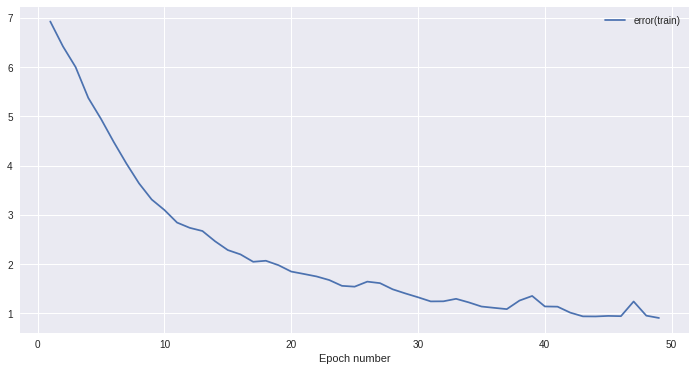

In [31]:
dyn_stats.plotStats()
plt.show()

In [32]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [33]:
ind = np.argmin(r2_scores)
ind

3918

In [34]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [35]:
r2_score(y_true=reals, y_pred=preds)

-1.1061449080605878e+31

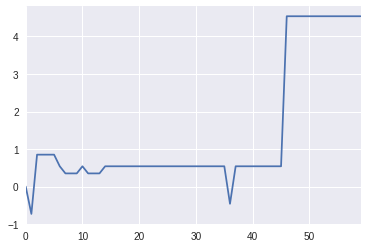

In [36]:
sns.tsplot(data=dp.inputs[ind].flatten())

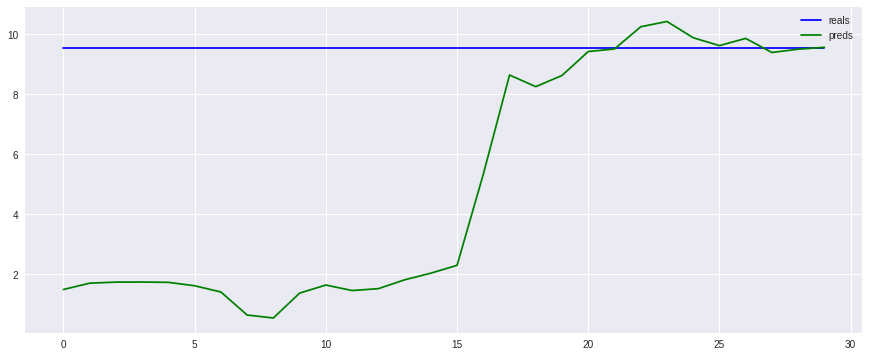

In [37]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [38]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 24.4 s, sys: 96 ms, total: 24.5 s
Wall time: 24.4 s


In [39]:
np.mean(dtw_scores)

31.506525364490965

In [40]:
coint(preds, reals)

(-1.2529879472888297,
 0.84347420956128705,
 array([-4.31395736, -3.55493606, -3.19393252]))

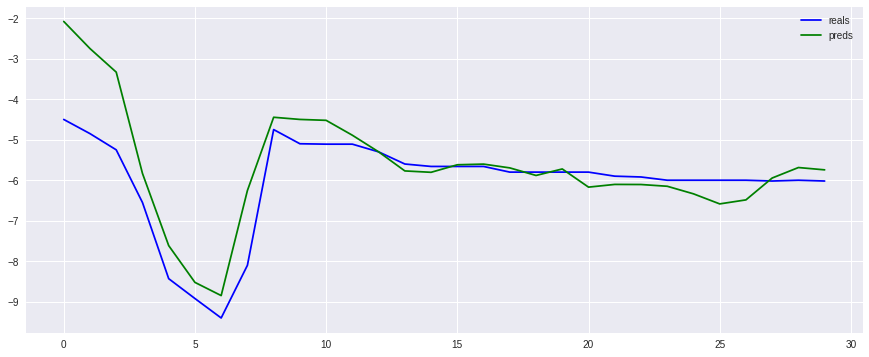

In [44]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [42]:
average_huber_loss = np.mean([np.mean(huber_loss(dp.targets[ind], preds_dict[ind]))
                              for ind in range(len(dp.targets))])
average_huber_loss

0.8081226406770371

#### Conclusion
GRUs after 50 epochs have mostly converged and the mean dtw is reduced from ~90 to ~30 and the visual result is good enough